In [45]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
import json
# import tqdm
import torch
from torch.optim  import Adam

from torch.utils.tensorboard import SummaryWriter

from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')
import src.mace.autoencoder  as ae
import src.mace.CSE_0D.dataset      as ds
import src.mace.CSE_0D.train        as tr
import src.mace.neuralODE    as nODE
from src.mace.CSE_0D.loss           import Loss
from src.mace.plotting  import plot_loss
import src.mace.utils as utils


%reload_ext autoreload
%autoreload 2

In [2]:
inputdirs = np.loadtxt('data/paths_data_C.txt', dtype=str)

### Retrieving the min & max values of the dataset

In [79]:
## density
rho_min = np.inf
rho_max = 0
## temperature
T_max = 0
## delta
delta_min = np.inf
delta_max = 0
## Av
Av_min = np.inf
Av_max = 0

dt_max = 0


lens = dict()

for i, path in enumerate(inputdirs):
    print(i, end='\r')

    mod = ds.CSEmod(path)

    ## check the length of the model
    if len(mod) != 135:
        lens[i] = len(mod)
    
    ## check the min and max of the parameters
    ## density
    rho_min_mod = min(mod.get_dens())
    rho_max_mod = max(mod.get_dens())
    if rho_min_mod < rho_min:
        rho_min = rho_min_mod
    if rho_max_mod > rho_max:
        rho_max = rho_max_mod
    ## Av
    Av_min_mod = min(mod.get_Av())
    Av_max_mod = max(mod.get_Av())
    if Av_min_mod < Av_min:
        Av_min = Av_min_mod
    if Av_max_mod > Av_max:
        Av_max = Av_max_mod
    ## temperature
    T_max_mod = max(mod.get_temp())
    if T_max_mod > T_max:
        T_max = T_max_mod
    ## delta
    delta_min_mod = min(mod.get_delta())
    delta_max_mod = max(mod.get_delta())
    if delta_min_mod < delta_min:
        delta_min = delta_min_mod
    if delta_max_mod > delta_max:
        delta_max = delta_max_mod

    ## dt
    dt_max_mod = max(mod.get_dt())
    if dt_max_mod > dt_max:
        dt_max = dt_max_mod

    


In [80]:
## density
print('dens:',rho_min, rho_max)
## temperature
print('temp: 10',T_max)
## delta
print('delta',delta_min, delta_max)
## Av
print('Av',Av_min, Av_max)

print('dt',dt_max)

dens: 0.008223 5009000000.0
temp: 10 1851.0
delta 0.0 0.9999
Av 2.141e-05 1246.0
dt 434800000000.0


In [83]:
meta = {'dens_min': rho_min,
        'dens_max': rho_max,
        'temp_min': 10.,
        'temp_max': T_max,
        'delta_min': delta_min,
        'delta_max': delta_max,
        'Av_min': Av_min,
        'Av_max': Av_max,
        'dt_max': dt_max
        }


json_object = json.dumps(meta, indent=4)
with open("/STER/silkem/MACE/data/minmax.json", "w") as outfile:
    outfile.write(json_object)

### Testing the dataset class

In [41]:
mod = ds.CSEmod(inputdirs[18241])
dt,n,p = mod.split_in_0D()

In [41]:
dt.shape, n.shape, p.shape

((80,), (81, 468), (80, 4))

In [42]:
n = n.reshape(81,468)
n.shape

(81, 468)

In [44]:
n[:-1].shape, n[1:].shape

((80, 468), (80, 468))

In [7]:
mod1 = ds.CSEmod(inputdirs[17982])
mod2 = ds.CSEmod(inputdirs[18241])
len(mod1), len(mod2)

(135, 81)

In [90]:
dt1, n1, p1 = mod1.split_in_0D()
dt2, n2, p2 = mod2.split_in_0D()

In [91]:
dt1.shape, n1.shape, p1.shape, dt2.shape, n2.shape, p2.shape


((134,), (134, 468), (134, 4), (80,), (80, 468), (80, 4))

In [93]:
h = np.concatenate((dt1, dt2), axis=0)
h.shape

(214,)

In [33]:
def generate_random_numbers(n, start, end):
    return np.random.randint(start, end, size=n)

# Generate 10 random integers between 1 and 100
random_numbers = generate_random_numbers(10, 1, 100)

In [68]:
dt, n, p = mod.split_in_0D()
delta = p[:,2]
# norm_delta = utils.normalise(np.log10(p[:,2]), np.log10(1e-100), np.log10(1e-100+0.999))
# norm_dens = utils.normalise(mod.)
# norm_delta

delta



array([7.226e-84, 1.930e-78, 2.241e-73, 1.196e-68, 3.093e-64, 4.071e-60,
       2.854e-56, 1.113e-52, 2.514e-49, 3.414e-46, 2.887e-43, 1.570e-40,
       5.665e-38, 1.393e-35, 2.396e-33, 2.953e-31, 2.664e-29, 1.795e-27,
       9.210e-26, 3.659e-24, 1.144e-22, 2.860e-21, 5.795e-20, 9.643e-19,
       1.335e-17, 1.555e-16, 1.542e-15, 1.315e-14, 9.743e-14, 6.327e-13,
       3.634e-12, 1.861e-11, 8.565e-11, 3.569e-10, 1.355e-09, 4.723e-09,
       1.519e-08, 4.532e-08, 1.262e-07, 3.294e-07, 8.095e-07, 1.881e-06,
       4.147e-06, 8.708e-06, 1.747e-05, 3.356e-05, 6.195e-05, 1.101e-04,
       1.890e-04, 3.137e-04, 5.047e-04, 7.888e-04, 1.200e-03, 1.778e-03,
       2.573e-03, 3.641e-03, 5.045e-03, 6.855e-03, 9.145e-03, 1.199e-02,
       1.548e-02, 1.968e-02, 2.468e-02, 3.053e-02, 3.732e-02, 4.508e-02,
       5.388e-02, 6.373e-02, 7.465e-02, 8.666e-02, 9.974e-02, 1.139e-01,
       1.290e-01, 1.451e-01, 1.622e-01, 1.800e-01, 1.987e-01, 2.180e-01,
       2.380e-01, 2.585e-01, 2.795e-01, 3.008e-01, 

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out


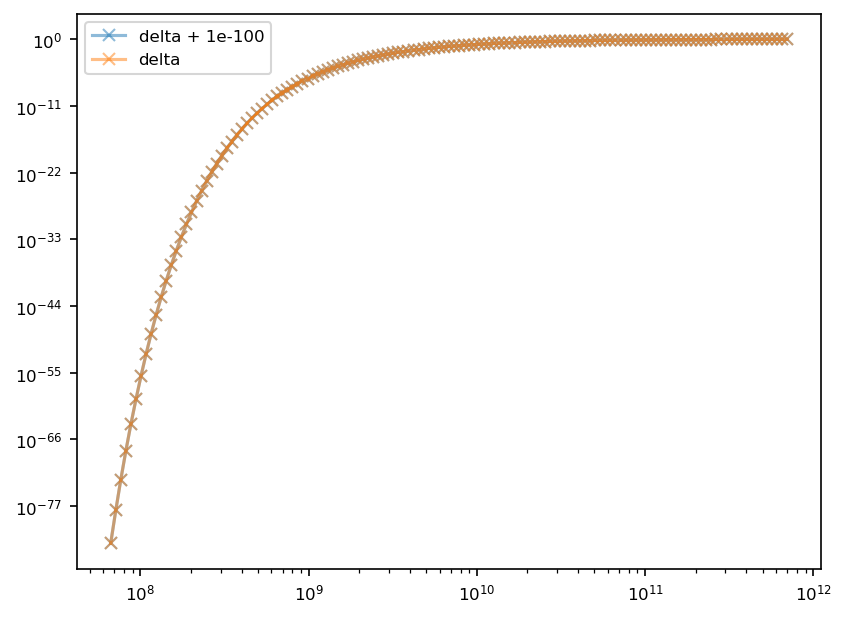

In [69]:
i = 2898-1
mod = ds.CSEmod(inputdirs[i])
print(inputdirs[i])


a=0.5

y = 0.01
# plt.loglog(mod.get_time(), mod.get_delta()+y, '-x', label = 'delta + '+str(y), alpha = a)
y = 1.e-100
plt.loglog(mod.get_time(), mod.get_delta()+y, '-x', label = 'delta + '+str(y), alpha = a)
plt.loglog(mod.get_time(), mod.get_delta(), '-x', label = 'delta', alpha = a)
# plt.loglog(mod.get_time(), mod.get_temp(), '-x', label = 'temp')
# plt.loglog(mod.get_time(), mod.get_dens(), '-x', label = 'dens')
# plt.loglog(mod.get_time(), mod.get_Av(), '-x', label = 'Av')
# plt.loglog(mod.get_time(), mod.get_abs_spec('CO' ),label = 'CO')
# plt.loglog(mod.get_time(), mod.get_abs_spec('H2O'),label = 'H2O')
# plt.loglog(mod.get_time(), mod.get_abs_spec('CH4'),label = 'CH4')
# plt.loglog(mod.get_time(), mod.n[:,-2],label = 'e-')

plt.legend()
plt.show()

### Testing the training

In [83]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

lr = 1.e-3
nb_epochs  = 2
losstype = 'mse'
z_dim = 10
dt_fract = 0.2
batch_size = 1
nb_samples = 100
n_dim = 468


train, test, data_loader, test_loader = ds.get_data(dt_fract=dt_fract,nb_samples=nb_samples, batch_size=batch_size, kwargs=kwargs)

model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, DEVICE = DEVICE)


Dataset:
------------------------------
total # of samples: 100
# training samples: 70
#  testing samples: 30
             ratio: 0.3


In [84]:
norm = {'mse' : 1,
        'rel' : 1,
        'evo' : 1}

fract = {'mse' : 1, 
         'rel' : 1,
         'evo' : 1}


## Make loss objects
trainloss = Loss(norm, fract)
testloss  = Loss(norm, fract)

trainloss.set_losstype(losstype)
testloss.set_losstype(losstype)

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("error", category=RuntimeWarning)
    try:
        opt = tr.train(model, lr, data_loader, test_loader, None, end_epochs = nb_epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, plot = False, log = True, show = True)
    except UserWarning as e:
        print("Caught:",e)
    


# trainloss.change_norm({'mse' :np.mean(trainloss.get_loss('mse')), # type: ignore
#                        'rel' :np.mean(trainloss.get_loss('rel')), # type: ignore
#                        'evo' :np.mean(trainloss.get_loss('evo'))})   # type: ignore
# testloss.change_norm({'mse' :np.mean(testloss.get_loss('mse')), # type: ignore
#                       'rel' :np.mean(testloss.get_loss('rel')), # type: ignore
#                       'evo' :np.mean(testloss.get_loss('evo'))}) # type: ignore

# tr.train(model, lr, data_loader, test_loader,None, end_epochs = nb_epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, start_epochs=ini_epochs, plot = False, log = True, show = True)



Model:         
learning rate: 0.001

>>> Training model...




Epoch 1 complete! 	Average loss train:  0.03421615317374819 	Average loss test:  0.013237423683206944




Epoch 2 complete! 	Average loss train:  0.007917934666507916 	Average loss test:  0.0041202322439687555

 	DONE!


In [ ]:
cutoff = 1e-20
nmin = np.log10(cutoff)
nmax = np.log10(0.85e-1)

def unscale(x, min, max):

    unscaled = x*np.abs(max-min)+min

    return unscaled

x = unscale(np.linspace(0,1,100), nmin, nmax)

n_un = unscale(n,nmin, nmax)
nhat_un = unscale(n_hat,nmin, nmax).detach().numpy()

fig = plt.figure(figsize = (8,7))
ax1 = fig.add_subplot((111))

ms = 3

i=-1
# specs = ['H2O', 'CO','C2H2', 'C2H', 'HCN', 'CN','OH', 'CH5+', 'SiH+','CH3C5N']
# for spec in specs:
#     idx = specs_dict[spec]
#     ax1.scatter(n_un[0][i][idx],nhat_un[0][i][idx],marker = 'o', alpha = alpha, label = spec) # type: ignore
ax1.scatter(n_un[0][i],nhat_un[0][i],marker = 'o',   label = 'all species') # type: ignore

ax1.plot(x,x, '--k', lw = 0.5)

ax1.set_xlabel('real log abundance')
ax1.set_ylabel('predicted log abundance')

ax1.grid(True, linestyle = '--', linewidth = 0.2)

ax1.legend(fontsize = 10)